### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- just use async langchain, support google vs openai vs anthropic transparently
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (newscatcher_sources, fn_initialize, fn_download_sources, fn_extract_urls,
                                 fn_verify_download, fn_extract_newscatcher, fn_extract_newsapi,
                                 fn_filter_urls, fn_topic_clusters, fn_topic_analysis, fn_download_pages, 
                                 fn_summarize_pages, fn_propose_cats,
                                 fn_compose_summary, fn_rewrite_summary, fn_is_revision_complete, fn_send_mail
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
LangChain         0.3.18
OpenAI            1.63.1
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Define LangGraph agent state graph

In [4]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [5]:
# sqlite schema to store previously processed headlines
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [6]:
# some debugging stuff, check a headline is cached properly
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")]
# xdf.loc[xdf["title"].str.startswith("NHTSA")]

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [7]:
class Agent:

    def __init__(self, state):

        self.state = state

        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("verify_download", self.verify_download)
        graph_builder.add_node("extract_newsapi_urls",
                               self.extract_newsapi_urls)
        # graph_builder.add_node("extract_newscatcher_urls",
        #                        self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "verify_download")
        graph_builder.add_edge("verify_download", "extract_newsapi_urls")
        graph_builder.add_edge("extract_newsapi_urls", "filter_urls")
        # graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                             })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories
        # self.conn = sqlite3.connect('lg_checkpointer.db')
        # self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,)
#                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def verify_download(self, state: AgentState) -> AgentState:
        self.state = fn_verify_download(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        try:
            self.state = fn_extract_newscatcher(state)
        except KeyError:
            log("Newscatcher download failed")
        return self.state

    def extract_newsapi_urls(self, state: AgentState) -> AgentState:
        try:
            self.state = fn_extract_newsapi(state)
        except KeyError:
            log("NewsAPI download failed")
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values")
        for event in events:
            try:
                if event.get('summary'):
                    print('summary created')
                    display(event.get('summary').replace("$", "\\\\$"))
                elif event.get('bullets'):
                    print('bullets created')
                    display("\n\n".join(
                        event.get('bullets')).replace("$", "\\\\$"))
                elif event.get('cluster_topics'):
                    print('cluster topics created')
                    display("\n\n".join(event.get('cluster_topics')))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby(
                        "src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc:
                print('run exception')
                print(exc)

        return self.state



In [8]:
def initialize_agent(do_download, before_date):
    # initial state
    state = AgentState({
        'AIdf': [{}],
        'before_date': before_date,
        'do_download': do_download,
        'sources': {},
        'sources_reverse': {},
        'bullets': '',
        'summary': '',
        'cluster_topics': [],
        'topics_str': '',
        'n_edits': 0,
        'edit_complete': False,
    })
    global thread_id
    thread_id = uuid.uuid4().hex
    log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}"
        )
    return state, Agent(state), thread_id


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
before_date = None
before_date = '2025-02-18 18:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


In [ ]:
AIdf

In [ ]:
# it will stop if check sources not passed
# or if we force a stop compiling with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)

aidf = pd.DataFrame(last_state.values["AIdf"])
aidf['id'].to_list()


In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-02-20 07:55:45,164 - AInewsbot - INFO - Initializing with before_date=2025-02-19 18:00, do_download=False, thread_id=1611b4dd44e94dcbb4561d490d9145d8


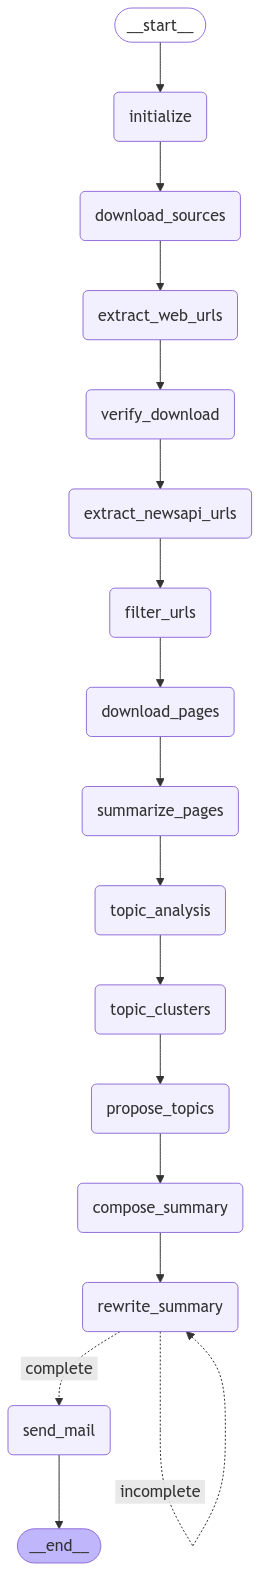

In [18]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-02-19 18:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [19]:
state = lg_agent.initialize(state)


2025-02-20 07:55:45,785 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-02-20 07:55:45,785 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-02-20 07:55:45,786 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-02-20 07:55:45,786 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-02-20 07:55:45,786 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-02-20 07:55:45,786 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-02-20 07:55:45,787 - AInewsbot - INFO - 

In [20]:
state = lg_agent.download_sources(state)


2025-02-20 07:55:46,296 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-02-20 07:55:46,297 - AInewsbot - INFO - Found 16 previously downloaded files
2025-02-20 07:55:46,297 - AInewsbot - INFO - htmldata/Hacker News Page 2 (02_20_2025 07_37_22 AM).html
2025-02-20 07:55:46,297 - AInewsbot - INFO - htmldata/Bloomberg Technology (02_20_2025 07_37_11 AM).html
2025-02-20 07:55:46,297 - AInewsbot - INFO - htmldata/Techmeme (02_20_2025 07_37_35 AM).html
2025-02-20 07:55:46,298 - AInewsbot - INFO - htmldata/The Verge AI (02_20_2025 07_37_46 AM).html
2025-02-20 07:55:46,298 - AInewsbot - INFO - htmldata/Ars Technica (02_20_2025 07_37_10 AM).html
2025-02-20 07:55:46,298 - AInewsbot - INFO - htmldata/Reddit multiple subreddits (02_20_2025 07_37_54 AM).html
2025-02-20 07:55:46,299 - AInewsbot - INFO - htmldata/VentureBeat AI (02_20_2025 07_37_57 AM).html
2025-02-20 07:55:46,299 - AInewsbot - INFO - htmldata/Hacker News Page 1 (02_20_2025 07_37_21 AM).html
2025-02-20 0

In [21]:
state = lg_agent.extract_web_urls(state)


2025-02-20 07:55:46,731 - AInewsbot - INFO - Parsing html files
2025-02-20 07:55:46,732 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (02_20_2025 07_37_10 AM).html
2025-02-20 07:55:46,784 - AInewsbot - INFO - parse_file - found 203 raw links
2025-02-20 07:55:46,787 - AInewsbot - INFO - parse_file - found 39 filtered links
2025-02-20 07:55:46,788 - AInewsbot - INFO - 39 links found
2025-02-20 07:55:46,788 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (02_20_2025 07_37_11 AM).html
2025-02-20 07:55:46,807 - AInewsbot - INFO - parse_file - found 200 raw links
2025-02-20 07:55:46,810 - AInewsbot - INFO - parse_file - found 17 filtered links
2025-02-20 07:55:46,811 - AInewsbot - INFO - 17 links found
2025-02-20 07:55:46,812 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (02_20_2025 07_37_08 AM).html
2025-02-20 07:55:46,831 - AInewsbot - INFO - parse_file - found 207 raw links
2025-02-20 07:55:46,834 - AInewsbot - INFO - parse_file 

In [22]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


id
src                  
Ars Technica       33
Bloomberg Tech     13
Business Insider   21
FT Tech            63
Feedly AI          34
Hacker News        26
Hacker News 2      23
HackerNoon         98
NYT Tech           19
Reddit             12
Techmeme          129
The Register      109
The Verge           4
VentureBeat        43
WSJ Tech           25
WaPo Tech          37

number of missing sources 0


set()

In [23]:
state = lg_agent.verify_download(state)


2025-02-20 07:55:47,847 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [24]:
state = lg_agent.extract_newsapi_urls(state)


2025-02-20 07:55:48,389 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-02-19T07:55:48 from NewsAPI


In [25]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


2025-02-20 07:55:49,010 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-02-19 18:00'
2025-02-20 07:55:49,687 - AInewsbot - INFO - URLs in orig_df: 789
2025-02-20 07:55:49,690 - AInewsbot - INFO - Existing URLs in DB: 219123
2025-02-20 07:55:49,746 - AInewsbot - INFO - New URLs in df filtered by URL: 347
2025-02-20 07:55:49,862 - AInewsbot - INFO - Existing src+title: 0
2025-02-20 07:55:49,862 - AInewsbot - INFO - New URLs in df filtered by src+title: 347
2025-02-20 07:55:49,875 - AInewsbot - INFO - Found 347 unique new headlines
2025-02-20 07:55:49,877 - AInewsbot - INFO - Found 345 unique new headlines
2025-02-20 07:56:01,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 07:56:01,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 07:56:01,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 20

id
src                 
Ars Technica       4
Bloomberg Tech     1
Business Insider   3
FT Tech            3
Feedly AI         29
Hacker News        6
Hacker News 2      8
HackerNoon         3
NYT Tech           2
NewsAPI           26
Techmeme          22
The Register       3
The Verge          2
VentureBeat        7
WSJ Tech           1

2025-02-20 07:56:14,753 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 6126
2025-02-20 07:56:14,754 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 6126
2025-02-20 07:56:14,755 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 6126
2025-02-20 07:56:14,758 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 6126
2025-02-20 07:56:47,193 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-20 07:56:47,193 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-20 07:56:47,193 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-20 07:56:47,193 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-20 07:56:47,195 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-20 07:56:47,195 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-20 07:56:47,195 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-20 07:56:47,

In [27]:
state = lg_agent.download_pages(state)


2025-02-20 08:25:38,143 - AInewsbot - INFO - Queuing URLs for scraping
2025-02-20 08:26:39,969 - AInewsbot - INFO - Processing page 0: https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/
2025-02-20 08:26:39,971 - AInewsbot - INFO - Processing page 1: https://venturebeat.com/security/a-stytch-in-time-connected-apps-untangles-authorization-tie-ups-for-ai-agents/
2025-02-20 08:26:39,971 - AInewsbot - INFO - Processing page 2: https://www.theregister.com/2025/02/20/a_big_ai_build_has/
2025-02-20 08:26:39,971 - AInewsbot - INFO - get_url(https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/) - starting get_url https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/
2025-02-20 08:26:39,972 - AInewsbot - INFO - Processing page 3: https://hackernoon.com/ai-can-outsmart-you-and-cybercriminals-know-it
2025-02-20 08:26:39,972 - AInewsbot - INFO - get_url(https://venturebea

2025-02-20 08:26:43,767 - AInewsbot - INFO - Processing page 18: https://www.techradar.com/computing/artificial-intelligence/are-you-polite-to-chatgpt-heres-where-you-rank-among-ai-chatbot-users
2025-02-20 08:26:43,767 - AInewsbot - INFO - get_url(https://www.techradar.com/computing/artificial-intelligence/are-you-polite-to-chatgpt-heres-where-you-rank-among-ai-chatbot-users) - starting get_url https://www.techradar.com/computing/artificial-intelligence/are-you-polite-to-chatgpt-heres-where-you-rank-among-ai-chatbot-users
2025-02-20 08:26:43,767 - AInewsbot - INFO - Processing page 19: https://www.etfdailynews.com/2025/02/19/artificial-intelligence-stocks-to-watch-today-february-16th/
2025-02-20 08:26:43,768 - AInewsbot - INFO - get_url(https://www.etfdailynews.com/2025/02/19/artificial-intelligence-stocks-to-watch-today-february-16th/) - starting get_url https://www.etfdailynews.com/2025/02/19/artificial-intelligence-stocks-to-watch-today-february-16th/
2025-02-20 08:26:43,768 - AInew

2025-02-20 08:26:46,523 - AInewsbot - INFO - get_url(https://www.techinasia.com/news/east-ventures-unveils-platform-ai-innovators-indonesia) - starting get_url https://www.techinasia.com/news/east-ventures-unveils-platform-ai-innovators-indonesia
2025-02-20 08:26:46,524 - AInewsbot - INFO - Processing page 34: https://www.thehindubusinessline.com/Package/elon-musk-spacex-tesla-cars-xai-grok3-latest-news-updates/article69237343.ece
2025-02-20 08:26:46,524 - AInewsbot - INFO - get_url(https://www.thehindubusinessline.com/Package/elon-musk-spacex-tesla-cars-xai-grok3-latest-news-updates/article69237343.ece) - starting get_url https://www.thehindubusinessline.com/Package/elon-musk-spacex-tesla-cars-xai-grok3-latest-news-updates/article69237343.ece
2025-02-20 08:26:46,526 - AInewsbot - INFO - Processing page 35: https://www.techtimes.com/articles/309438/20250220/elon-musks-grok-3-vs-chatgpt-vs-deepseek-which-best-ai-chatbot-present-today.htm
2025-02-20 08:26:46,528 - AInewsbot - INFO - get_

2025-02-20 08:26:50,287 - AInewsbot - INFO - Processing page 49: https://arstechnica.com/google/2025/02/googles-new-ai-generates-hypotheses-for-researchers/
2025-02-20 08:26:50,287 - AInewsbot - INFO - get_url(https://arstechnica.com/google/2025/02/googles-new-ai-generates-hypotheses-for-researchers/) - starting get_url https://arstechnica.com/google/2025/02/googles-new-ai-generates-hypotheses-for-researchers/
2025-02-20 08:26:50,945 - AInewsbot - INFO - get_url(Google launches a Gemini 2.0-based AI co-scientist tool to help biomedical scientists create novel hypotheses and speed up research, available to select testers) - Saving Google_launches_a_Gemini_2.0-based_AI_co-scientist_tool_to_help_biomedical_scientists_create_novel_hypotheses_and_speed_up_research__available_to_select_testers.html as utf-8
2025-02-20 08:26:50,946 - AInewsbot - INFO - Processing page 50: https://www.geeky-gadgets.com/grok-3-ai-review/
2025-02-20 08:26:50,946 - AInewsbot - INFO - get_url(https://www.geeky-gad

2025-02-20 08:26:51,945 - AInewsbot - INFO - Processing page 65: https://www.wsj.com/tech/microsoft-claims-creation-of-new-state-of-matter-in-quantum-computing-breakthrough-2c10f5ac
2025-02-20 08:26:51,945 - AInewsbot - INFO - get_url(https://www.wsj.com/tech/microsoft-claims-creation-of-new-state-of-matter-in-quantum-computing-breakthrough-2c10f5ac) - starting get_url https://www.wsj.com/tech/microsoft-claims-creation-of-new-state-of-matter-in-quantum-computing-breakthrough-2c10f5ac
2025-02-20 08:26:52,657 - AInewsbot - INFO - get_url(Lambda, which offers cloud services and computers to train AI, raised a $480M Series D, sources say at a $2.5B post-money valuation, taking its funding to $863M) - Saving Lambda__which_offers_cloud_services_and_computers_to_train_AI__raised_a__480M_Series_D__sources_say_at_a__2.5B_post-money_valuation__taking_its_funding_to__863M.html as utf-8
2025-02-20 08:26:52,661 - AInewsbot - INFO - Processing page 66: https://www.nytimes.com/2025/02/19/technology/m

2025-02-20 08:27:00,498 - AInewsbot - INFO - get_url(https://www.christopherspenn.com/2025/02/mind-readings-ask-ai-what-you-can-improve/) - starting get_url https://www.christopherspenn.com/2025/02/mind-readings-ask-ai-what-you-can-improve/
2025-02-20 08:27:00,499 - AInewsbot - INFO - Processing page 78: https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards
2025-02-20 08:27:00,499 - AInewsbot - INFO - get_url(https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards) - starting get_url https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards
2025-02-20 08:27:01,327 - AInewsbot - INFO - get_url(Microsoft shows progress toward real-time AI-generated game worlds) - Saving Microsoft_shows_progress_toward_real-time_AI-generated_game_worlds.html as utf-8
2025-02-20 08:27:01,331 - AInewsbot - INFO - Processing page 79: https://techcrunch.co

2025-02-20 08:27:04,029 - AInewsbot - INFO - get_url(https://techcrunch.com/2025/02/19/sanas-taps-ai-to-change-call-center-workers-accents-in-real-time/) - starting get_url https://techcrunch.com/2025/02/19/sanas-taps-ai-to-change-call-center-workers-accents-in-real-time/
2025-02-20 08:27:04,030 - AInewsbot - INFO - Processing page 96: https://www.businessinsider.com/satya-nadella-microsoft-new-majorana-chip-quantum-breakthrough-state-matter-2025-2
2025-02-20 08:27:04,031 - AInewsbot - INFO - get_url(https://www.businessinsider.com/satya-nadella-microsoft-new-majorana-chip-quantum-breakthrough-state-matter-2025-2) - starting get_url https://www.businessinsider.com/satya-nadella-microsoft-new-majorana-chip-quantum-breakthrough-state-matter-2025-2
2025-02-20 08:27:04,032 - AInewsbot - INFO - Processing page 97: https://kyunghyuncho.me/softmax-forever-or-why-i-like-softmax/
2025-02-20 08:27:04,032 - AInewsbot - INFO - get_url(https://kyunghyuncho.me/softmax-forever-or-why-i-like-softmax/)

2025-02-20 08:27:06,769 - AInewsbot - INFO - get_url(https://www.techtimes.com/articles/309442/20250220/volvos-es90-packing-insane-ai-power-nvidia-chips-make-it-supercomputer-wheels.htm) - starting get_url https://www.techtimes.com/articles/309442/20250220/volvos-es90-packing-insane-ai-power-nvidia-chips-make-it-supercomputer-wheels.htm
2025-02-20 08:27:06,778 - AInewsbot - INFO - Processing page 112: https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/
2025-02-20 08:27:06,780 - AInewsbot - INFO - get_url(https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/) - starting get_url https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/
2025-02-20 08:27:07,246 - AInewsbot - INFO - get_url(Trump Team Plans Mass Firings at Key Agency for AI and Chips) - Saving Trump_Team_Plans_Mass_Firings_at_Key_Agency_for_AI_and_Chips.html as utf-8
2025-02-20 08:27:07,249 - AInewsbot - INFO - Processing page 113: https://www.zdnet.com/article/what-is-perplexity-deep-resea

In [28]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


2025-02-20 08:28:34,982 - AInewsbot - INFO - Starting summarize
2025-02-20 08:28:35,039 - AInewsbot - INFO - fetch_all_summaries - Page title: A Step-by-Step Guide to Create Free Custom AI Agents Using ChatGPT-4o - AI Agents Post
Social card title: A Step-by-Step Guide to Create Free Custom AI Agents Using ChatGPT-4o - AI Agents Post
Social card description: A Step-by-Step Guide to Create Free Custom AI Agents Using ChatGPT-4o

2025-02-20 08:28:35,222 - AInewsbot - INFO - fetch_all_summaries - Page title: A Stytch in time: Connected Apps untangles authorization tie-ups for AI agents | VentureBeat
Social card title: A Stytch in time: Connected Apps untangles authorization tie-ups for AI agents
Social card description: Stytch Connected Apps enables AI agents and third-party apps to authenticate, access data and take action on behalf of users.

2025-02-20 08:28:35,247 - AInewsbot - INFO - fetch_all_summaries - Page title: A big AI infrastructure build has ‘stalled’ • The Register
Social c

2025-02-20 08:28:35,916 - AInewsbot - INFO - fetch_all_summaries - Page title: AI startup Baseten raises $75 million following DeepSeek's emergence
Social card title: AI startup Baseten raises $75 million following DeepSeek's emergence
Social card description: Baseten, a startup that runs artificial intelligence models for clients on their cloud infrastructure, has raised $75 million in funding, the company said.

2025-02-20 08:28:35,949 - AInewsbot - INFO - fetch_all_summaries - Page title: Breaking down Grok 3: The AI model that could redefine the industry | VentureBeat
Social card title: Breaking down Grok 3: The AI model that could redefine the industry
Social card description: Grok-3 still hasn't fully shipped yet. But it will surely set the tone for how other AI labs release future models.

2025-02-20 08:28:35,973 - AInewsbot - INFO - fetch_all_summaries - Page title: Subscribe to read
Social card title: CEOs’ forced smiles show the limits of AI-driven investing
Social card descr

2025-02-20 08:28:36,735 - AInewsbot - INFO - fetch_all_summaries - Page title: Gemini in Google Meet Can Now Suggest ‘Next Steps’ After Meetings | Technology News
Social card title: Gemini in Google Meet Can Now Suggest ‘Next Steps’ After Meetings
Social card description: The ‘Next Steps’ feature is being added to Gemini’s note-taking capability in Google Meet.

2025-02-20 08:28:36,768 - AInewsbot - INFO - fetch_all_summaries - Page title: Getting Started With Apple's Vision Framework: A Developer's Perspective  | HackerNoon
Social card title: Getting Started With Apple's Vision Framework: A Developer's Perspective  | HackerNoon
Social card description: Main scenarios of using Vision with code examples that will help you understand how to work with it, understand that it is not difficult and start applying it i

2025-02-20 08:28:36,831 - AInewsbot - INFO - fetch_all_summaries - Page title: These 9 Discounted Stocks Are Boosting Their Sales With AI: Goldman - Business Insider
Social car

2025-02-20 08:28:37,616 - AInewsbot - INFO - fetch_all_summaries - Page title: AI cloud startup Lambda raises $480 million in new round; Nvidia among investors | Reuters
Social card title: AI cloud startup Lambda raises $480 million in new round; Nvidia among investors
Social card description: Lambda, a cloud computing firm specializing in providing hardware and services to power artificial intelligence development, has raised $480 million in a Series D equity round from investors including Nvidia , the company told Reuters.

2025-02-20 08:28:37,648 - AInewsbot - INFO - fetch_all_summaries - Page title: Large Language Diffusion Models
Social card title: SOCIAL MEDIA TITLE TAG
Social card description: SOCIAL MEDIA DESCRIPTION TAG TAG

2025-02-20 08:28:37,668 - AInewsbot - INFO - fetch_all_summaries - Page title: Magma: A Foundation Model for Multimodal AI Agents

2025-02-20 08:28:37,687 - AInewsbot - INFO - fetch_all_summaries - Page title: Bloomberg - Are you a robot?

2025-02-20 08:28

2025-02-20 08:28:38,236 - AInewsbot - INFO - fetch_all_summaries - Page title: Spore.Bio raises $23M to apply machine learning to microbiology testing | TechCrunch
Social card title: Spore.Bio raises $23M to apply machine learning to microbiology testing | TechCrunch
Social card description: Recalls in the food and beverage industry due to contamination incidents can be catastrophic for a company. Not only do companies have to pay fines and

2025-02-20 08:28:38,271 - AInewsbot - INFO - fetch_all_summaries - Page title: Peer to Peer AI: Is This Era Upon Us? | HackerNoon
Social card title: Peer to Peer AI: Is This Era Upon Us? | HackerNoon
Social card description: Is there such a thing as peer to peer AI, and what does DeepSeek have to do with it?

2025-02-20 08:28:38,327 - AInewsbot - INFO - fetch_all_summaries - Page title: People are increasingly swapping Google for the likes of ChatGPT, according to a major survey – here’s why | TechRadar
Social card title: People are increasingly sw

2025-02-20 08:28:39,505 - AInewsbot - INFO - fetch_all_summaries - Page title: Turkey’s translators are training their AI replacements - Rest of World
Social card title: Turkey’s translators are training the AI tools that will replace them
Social card description: Human fallout may include being replaced by LLMs, diminished skills, and fewer career options for all but the elite scholars. 

2025-02-20 08:28:39,517 - AInewsbot - INFO - fetch_all_summaries - 
2025-02-20 08:28:39,547 - AInewsbot - INFO - fetch_all_summaries - Page title: Tech in Asia - Connecting Asia's startup ecosystem

2025-02-20 08:28:39,581 - AInewsbot - INFO - fetch_all_summaries - Page title: Founder Who's Raised $280 Million Shares How She Picked Cap Table - Business Insider
Social card title: Uber and Nvidia back my startup, which has raised $280M. Here's how we impressed investors and chose the right ones.
Social card description: Raquel Urtasun, the founder of Waabi, shared her strategy for picking investors in 

2025-02-20 08:28:42,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:42,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:42,792 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:42,831 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:42,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:42,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:42,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:43,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:43,048 - httpx 

2025-02-20 08:28:44,514 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:44,517 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:44,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:44,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:44,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:44,720 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:44,746 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:44,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:44,988 - httpx 

In [29]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))

- There is a growing trend and demand for AI agents, with platforms like ChatGPT-4o enabling users to create personalized, no-code AI agents to automate tasks. Prominent figures like Jensen Huang of NVIDIA highlight the significance and economic potential of AI agents by 2025.

- Five platforms, including Taskade, Relevance AI, Botpress, Invicta AI, and AgentGPT by Reworkd, allow users to build custom AI agents; this guide uses You.com to demonstrate the step-by-step process of creating AI agents using ChatGPT-4o.

- Custom AI agents built with ChatGPT-4o can be personalized with names, descriptions, training sources, instructions, and advanced features, offering autonomous functionality with minimal human intervention to streamline workflows.

In [30]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
state = lg_agent.topic_analysis(state)



2025-02-20 08:28:49,508 - AInewsbot - INFO - start free-form topic extraction using gpt-4o-2024-11-20
2025-02-20 08:28:57,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:57,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:28:59,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:00,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:01,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:01,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:01,868 - AInewsbot - INFO - 120 free-form topics extracted
2025-02-20 08:29:01,870 - AInewsbot - INFO - Starting assigned topic extraction using gpt-4o-min

2025-02-20 08:29:01,910 - AInewsbot - INFO - Canonical topic fintech
2025-02-20 08:29:01,910 - AInewsbot - INFO - Canonical topic china
2025-02-20 08:29:01,910 - AInewsbot - INFO - Canonical topic bias and fairness
2025-02-20 08:29:01,910 - AInewsbot - INFO - Canonical topic cryptocurrency
2025-02-20 08:29:01,911 - AInewsbot - INFO - Canonical topic semiconductor chips
2025-02-20 08:29:01,911 - AInewsbot - INFO - Canonical topic korea
2025-02-20 08:29:01,912 - AInewsbot - INFO - Canonical topic quantum computing
2025-02-20 08:29:01,912 - AInewsbot - INFO - Canonical topic health & fitness
2025-02-20 08:29:01,912 - AInewsbot - INFO - Canonical topic trusted tester program
2025-02-20 08:29:01,912 - AInewsbot - INFO - Canonical topic scams
2025-02-20 08:29:01,912 - AInewsbot - INFO - Canonical topic manufacturing
2025-02-20 08:29:01,912 - AInewsbot - INFO - Canonical topic gen ai
2025-02-20 08:29:01,913 - AInewsbot - INFO - Canonical topic taiwan
2025-02-20 08:29:01,913 - AInewsbot - INFO

2025-02-20 08:29:08,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,111 - httpx 

2025-02-20 08:29:08,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,569 - httpx 

2025-02-20 08:29:08,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:08,895 - httpx 

2025-02-20 08:29:09,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,345 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,350 - httpx 

2025-02-20 08:29:09,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:09,834 - httpx 

2025-02-20 08:29:10,379 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:10,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:10,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:10,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:10,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:10,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:10,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:10,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:10,435 - httpx 

2025-02-20 08:29:11,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:11,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:11,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:11,072 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:11,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:11,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:11,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:11,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:11,099 - httpx 

2025-02-20 08:29:12,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:12,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:12,390 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:12,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:12,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:12,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:12,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:12,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:12,546 - httpx 

2025-02-20 08:29:14,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:14,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:14,345 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:14,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:14,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:14,514 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:14,532 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:14,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:14,651 - httpx 

In [33]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[1].title_topic_str))

A Stytch in time: Connected Apps untangles authorization tie-ups for AI agents (Topics: AI Accessibility, AI Assistant Penny, Chatbots, Code Assistants, Cross-Domain Login, Cybersecurity, Economics, Finance, Fintech, Gen AI, Job Automation, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Saas Identity Management, Safety And Alignment, Stytch Connected Apps, Virtual Assistants)

In [34]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].bullet))

[A Step-by-Step Guide to Create Free Custom AI Agents Using ChatGPT-4o - AI Agents Post - aiagentspost.com](https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/)

Topics: AI Agents, Chatbots, Chatgpt-4O, Economics, Gen AI, Jensen Huang, Job Automation, Language Models, Science, Task Automation, Virtual Assistants

- There is a growing trend and demand for AI agents, with platforms like ChatGPT-4o enabling users to create personalized, no-code AI agents to automate tasks. Prominent figures like Jensen Huang of NVIDIA highlight the significance and economic potential of AI agents by 2025.

- Five platforms, including Taskade, Relevance AI, Botpress, Invicta AI, and AgentGPT by Reworkd, allow users to build custom AI agents; this guide uses You.com to demonstrate the step-by-step process of creating AI agents using ChatGPT-4o.

- Custom AI agents built with ChatGPT-4o can be personalized with names, descriptions, training sources, instructions, and advanced features, offering autonomous functionality with minimal human intervention to streamline workflows.



In [35]:
state = lg_agent.topic_clusters(state)


2025-02-20 08:29:40,546 - AInewsbot - INFO - Fetching embeddings for 120 headlines
2025-02-20 08:29:41,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-20 08:29:42,086 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2025-02-20 08:29:42,114 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-02-20 08:29:43,544 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-02-20 08:29:44,996 - AInewsbot - INFO - Cluster with DBSCAN
2025-02-20 08:29:45,082 - AInewsbot - INFO - Found 8 clusters


title_topic_str
0                                                                                         People are increasingly swapping Google for the likes of ChatGPT, according to a major survey  heres why (Topics: AI Search Preferences, Chatbots, Chatgpt Adoption, Code Assistants, Consumer Behavior Trends, Conversational AI Assistants, Gen AI, Language Models, Recommendation Systems, Science, Speech Recognition & Synthesis, Traditional Search Engine Decline, Uk, Virtual Assistants)
1                                                                                                                                                                                                                                           A Step-by-Step Guide to Create Free Custom AI Agents Using ChatGPT-4o - AI Agents Post (Topics: AI Agents, Chatbots, Chatgpt-4O, Economics, Gen AI, Jensen Huang, Job Automation, Language Models, Science, Task Automation, Virtual Assistants)
2  Mira Network Launches Klok: A ChatGPT Alternative with Multiple AI Models and Rewards (Topics: AI Accessibility, Bias And Fairness, Chatbots, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Systems, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Infrastructure, Internet Of Things, Language Models, Mira Network Klok App, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Trust Layer For AI, Venture Capital)

2025-02-20 08:29:45,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:45,925 - AInewsbot - INFO - I dub this cluster: Advancements in AI and Chatbots


title_topic_str
3                                                                                                      An interview with Accel's Harry Nelis, who led early investments in Zepz and Kayak, on how the European startup industry has changed, the AI boom, and more (Topics: Insufficient Content, No Content Available)
4                                                                                                                                                                                                    East Ventures unveils platform for AI innovators in Indonesia (Topics: Insufficient Content, No Content Available)
5  Crunchbases AI can predict startup success with 95% accuracywill it change investing? (Topics: AI For Market Intelligence, Crunchbase Transformation, Economics, Finance, Funding, Gen AI, Language Models, Mergers And Acquisitions, Recommendation Systems, Science, Startup Predictions, Stocks, Venture Capital)

2025-02-20 08:29:46,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:46,626 - AInewsbot - INFO - I dub this cluster: AI in Startup Innovation


title_topic_str
6                                                                                                                                                                                                                                                                                                                                                                                                          Apple reveals iPhone 16e with AI features for $599 (Topics: Insufficient Content, No Content Available)
7  Apple unveils the $599+ iPhone 16e with a 6.1" display, A18, 48MP camera, Apple Intelligence, the C1 cellular modem, USB-C, and no MagSafe, shipping February 28 (Topics: A18 Chip, Advanced AI Features, AI Accessibility, Apple Product Updates, Computer Vision, Economics, Facial Recognition, Gen AI, Hardware, Iphone 16E Unveiling, Japan, Language Models, Privacy, Privacy & Surveillance, Products, Science, Semiconductor Chips, Speech Recognition & Synthesis, Transportation, Virtual Assistants)
8                                                                                                     Apple unveils its first in-house cellular modem, the C1, with 5G, to replace Qualcomm modems, saying it is the most power-efficient modem ever on an iPhone (Topics: 5G Connectivity Enhancement, Apple C1 Modem, Economics, Energy, Hardware, Infrastructure, Iphone Modem Innovation, Japan, Manufacturing, Products, Qualcomm Replacement, Science, Semiconductor Chips, Stocks, Testing, Transportation)
9                                                                                                                                        Apple Unveils New Lower-Priced iPhone With A.I. Features (Topics: AI Accessibility, AI-Powered Notifications, Apple Intelligence, Authors & Writing, China, Computer Vision, Face Id Integration, Facial Recognition, Gen AI, Hardware, India, Iphone 16E Features, Japan, Privacy, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Virtual Assistants)

2025-02-20 08:29:47,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:47,845 - AInewsbot - INFO - I dub this cluster: Apple's Innovation in AI and Hardware


title_topic_str
10                                                                                                                                                                                                                                Lambda, which offers cloud services and computers to train AI, raised a $480M Series D, sources say at a $2.5B post-money valuation, taking its funding to $863M (Topics: Chatbots, Cloud Computing Services, Deals, Economics, Finance, Funding, Gen AI, Governance, Hardware, Lambda AI Funding, Language Models, Open Source, Open-Source AI Models, Products, Science, Semiconductor Chips, Stocks, Venture Capital, Virtual Assistants)
11                                                                                                                                                                                                                                                                                                       Bain Capital Backs Israeli AI Cybersecurity Startup Dream at $1.1 Billion Valuation (Topics: AI Cybersecurity, Cybersecurity, Deals, Dream Startup, Finance, Funding, Gen AI, Governance, Government Partnerships, Infrastructure, Jobs & Careers, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Venture Capital)
12                                                                                                                                                                                                         Augury, which uses AI to detect malfunctions in factory machines, raised a $72.5M Series F, potentially rising to ~$100M, led by Lightrock at a $1B+ valuation (Topics: Augury AI Startup, Deals, Economics, Finance, Funding, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Machine Operations Analysis, Manufacturing, Predictive Maintenance, Products, Safety And Alignment, Science, Supply Chain Optimization, Venture Capital)
13                                                                                         Cambridge, MA-based OpenEvidence, which offers an AI chatbot for physicians, raised $75M from Sequoia at a $1B valuation, taking its total funding to $100M+ (Topics: AI Accessibility, AI In Healthcare, Chatbots, Cognitive Science, Consciousness, Deals, Doctor Assistance AI, Education, Ethics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Inequality, Language Models, Openevidence Medical Chatbot, Opinion, Products, Review, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Testing, Venture Capital, Virtual Assistants)
14                                                                                                                                                                                                                                                                                        Baseten, which helps companies launch open-source or custom AI models, raised $75M led by IVP and Spark Capital at an $825M valuation and claims 100+ customers (Topics: AI Cloud Deployment, Baseten Startup Growth, Cost-Effective AI Solutions, Deals, Economics, Finance, Funding, Gen AI, Hardware, India, Infrastructure, Language Models, Products, Science, Venture Capital)
15  Sanas, whose tech changes call center workers' accents in real time using AI, raised a $65M Series B at a $500M+ valuation led by Quadrille and Teleperformance (Topics: AI Accessibility, Bias And Fairness, Cultural And Ethical Implications, Deals, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Global Communication Barriers, India, Inequality, Intellectual Property, Ipos, Jobs & Careers, Labor Market, Mergers And Acquisitions, Opinion, Products, Real-Time Speech Algorithms, Safety And Alignment, Sanas Accent Adjustment, Science, Society & Culture, Speech Recognition & Synthesis, Startup Investment Success, Stocks, Venture Capital)

2025-02-20 08:29:48,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:48,576 - AInewsbot - INFO - I dub this cluster: AI Startups Securing Major Funding


title_topic_str
16  Grok to be a standalone app for MacOS, Windows (Topics: Chatbots, Comparative AI Benchmarks, Deals, Economics, Finance, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Mergers And Acquisitions, Musk'S Platform X Funding, Politics, Products, Stocks, Venture Capital, Virtual Assistants, Xai Chatbot Grok, Xai Grok 3, Xai'S Grok 3)
17                                                                                                                                                Grok 3: Another win for the bitter lesson (Topics: Chatbots, Gen AI, Infrastructure, Infrastructure Optimization In AI, Language Models, Large-Scale AI Computation, Science, Xai Grok 3, Xai'S Grok 3)
18                                                                                                      Breaking down Grok 3: The AI model that could redefine the industry (Topics: AI Model Development, Code Assistants, Ethics, Gen AI, Intellectual Property, Language Models, Open Source, Open Source Policies, Science, Xai Grok 3, Xai'S Grok 3)
19                               Is Grok-3 putting software engineer jobs at risk? Musk's xAI team says AI chatbot saved hundreds of hours on coding (Topics: AI In Software Engineering, Code Assistants, Gen AI, Impact On Employment, Job Automation, Jobs & Careers, Labor Market, Products, Safety And Alignment, Science, Xai Grok 3, Xai'S Grok 3)

2025-02-20 08:29:49,480 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:49,490 - AInewsbot - INFO - I dub this cluster: Grok 3 and AI Job Impact


title_topic_str
20                                                                                                                                                                                                                                                                Google Meet's Gemini AI Now Auto-Generates Action Items from Meetings (Topics: AI Accessibility, AI In Team Coordination, Code Assistants, Gemini AI Applications, Gen AI, Google Meet Enhancements, Job Automation, Language Models, Products, Retrieval Augmented Generation, Virtual Assistants)
21                                                                                                                                                                                                                                                                                             Google is removing Gemini support from the main Google app on iOS, pushing users to download the standalone Gemini app that launched in November 2024 (Topics: Customer Service, Gemini App For Ios, Products, Standalone Application Development, User Notifications)
22  Google launches a Gemini 2.0-based AI co-scientist tool to help biomedical scientists create novel hypotheses and speed up research, available to select testers (Topics: AI Accessibility, AI-Driven Hypothesis Generation, Artificial General Intelligence, Code Assistants, Cognitive Science, Consciousness, Education, Gen AI, Google AI Technology, Insufficient Content, Job Automation, Language Models, Reinforcement Learning, Retrieval Augmented Generation, Review, Science, Scientific Advancement Tools, Singularity, Testing, Virtual Assistants)
23                                                                                                                                                                                                                                                                                                                  Google Reportedly Teases New Features to Gemini Advanced Users, Removes Older Gemini 1.5 Models (Topics: Advanced Gemini AI Models, Gen AI, Google Gemini Updates, Language Models, Music, Products, Video And Multimedia AI, Virtual Assistants)
24                                                                                                                                                                                                                                                                                                                                                   Gemini in Google Meet Can Now Suggest Next Steps After Meetings (Topics: AI Accessibility, AI-Powered Productivity Tools, Gemini AI Features, Gen AI, Google Meet, Meeting Accessibility Improvements, Products)

2025-02-20 08:29:52,753 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:52,763 - AInewsbot - INFO - I dub this cluster: Google's Gemini AI Innovations


title_topic_str
25                                                                                                                                                                                         Microsoft demonstrates working qubits based on exotic physics (Topics: Climate, Energy, Hardware, Majorana Quasiparticles, Microsoft Quantum Advancements, Microsoft Quantum Computing, Microsoft Research, Policy And Regulation, Products, Quantum Computing, Quantum Hardware Development, Safety And Alignment, Scalable Quantum Computing, Science, Semiconductor Chips, Sustainability)
26                                                                                                                                                                                                                                                                                                                                                                                                                                                  Microsoft Claims Quantum Computing Breakthrough by Creating New State of Matter (Topics: Insufficient Content, No Content Available)
27                                                                                                                                                                                                                                                               Microsoft claims quantum breakthrough after 20-year pursuit of elusive particle (Topics: Climate, Energy, Fundamental Physics, Hardware, History, Microsoft Quantum Computing, Microsoft Research, Policy And Regulation, Quantum Computing, Safety And Alignment, Scalable Quantum Computing, Science, Sustainability)
28                                                                                                                                                                    Microsoft unveils Majorana 1 quantum processor (Topics: Climate, Energy, Finance, Governance, Hardware, Healthcare, Infrastructure, Majorana 1 Qpu, Microsoft Quantum Computing, Microsoft Research, Military, Nuclear, Policy And Regulation, Products, Quantum Computing, Safety And Alignment, Scalable Quantum Computing, Science, Semiconductor Chips, Society & Culture, Sustainability, Topological Qubits)
29                                                                                                              Microsoft says it has harnessed a new state of matter using particles called Majorana fermions, a significant breakthrough to create workable topological qubits (Topics: Climate, Energy, Hardware, History, Microsoft Quantum Computing, Microsoft Research, Microsoft'S Quantum Breakthroughs, Policy And Regulation, Quantum Computing, Quantum Technology, Safety And Alignment, Scalable Quantum Computing, Science, Sustainability, Topological Quantum Machines)
30  Microsoft unveils the Majorana 1, its first quantum processor that uses Majorana particles instead of electrons, with the potential to fit a million qubits (Topics: Climate, Energy, Finance, Governance, Hardware, Healthcare, Infrastructure, Manufacturing, Microsoft Darpa Collaboration, Microsoft Quantum Computing, Microsoft Research, Military, Nuclear, Policy And Regulation, Products, Quantum Computing, Quantum Processor Innovation, Safety And Alignment, Scalable Quantum Computing, Science, Semiconductor Chips, Sustainability, Topological Qubit Architecture)
31                                                                                                                                                                                                              Microsoft Says It Has Created a New State of Matter to Power Quantum Computers (Topics: Climate, Energy, Gen AI, Hardware, Healthcare, Microsoft Quantum Computing, Microsoft Research, Policy And Regulation, Products, Quantum Computing, Quantum Mechanics, Safety And Alignment, Scalable Quantum Computing, Science, Sustainability, Topological Qubit Development)

2025-02-20 08:29:55,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:55,441 - AInewsbot - INFO - I dub this cluster: Microsoft Quantum Computing Innovations


title_topic_str
32                                    Microsofts Muse AI can design video game worlds after watching you play (Topics: 3D Environment Simulation, AI Accessibility, Art & Design, Code Assistants, Computer Vision, Entertainment, Gaming, Gen AI, Generative AI Enhancements, Generative AI In Gaming, Infrastructure, Intellectual Property, Jobs & Careers, Language Models, Manufacturing, Microsoft Research, Muse AI Applications, Music, Open Source, Products, Retrieval Augmented Generation, Science, Society & Culture, Sports, Supply Chain Optimization, Testing, Tv & Film & Movies, Virtual & Augmented Reality)
33  Microsoft boffins promise entire game worlds made from AI slopWHAM, bam, no thank you, ma'am?AI + ML21 hrs|15 (Topics: 3D Game Development, AI Doom, Art & Design, Bias And Fairness, Disinformation, Entertainment, Ethics, Gaming, Gen AI, Generative AI Challenges, Generative AI In Gaming, Inequality, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Microsoft Research, Music, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Science, Society & Culture, Sports, Tv & Film & Movies, Virtual & Augmented Reality, Wham AI Model)
34                                                                                                                                                                                       Microsoft shows progress toward real-time AI-generated game worlds (Topics: Art & Design, Computer Vision, Entertainment, Gameplay Sequence Simulation, Gaming, Gen AI, Generative AI In Gaming, Intellectual Property, Jobs & Careers, Language Models, Microsoft AI Research, Microsoft Research, Products, Retrieval Augmented Generation, Science, Sports, Testing, Tv & Film & Movies, Virtual & Augmented Reality, Wham AI Tool)
35                                                                                                                                                                                                                                                                                                                               Muse is Xboxs generative AI model for gameplay ideation (Topics: 3D Game Physics, AI Accessibility, Entertainment, Ethics, Gaming, Gen AI, Generative AI In Gaming, Microsoft Research, Muse AI For Gameplay, Open Source, Products, Responsible AI Principles, Safety And Alignment, Science)
36                                                                                                                                                          Xboxs AI initiative with Muse is an attempt to read the tea leaves, not the room (Topics: AI Doom, Art & Design, Code Assistants, Entertainment, Ethics, Gaming, Gen AI, Generative AI In Gaming, Generative AI In Xbox Gaming, Hardware, Industry Response To AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Microsoft Research, Opinion, Preservation Of Gaming History, Products, Society & Culture, Sports, Tv & Film & Movies)
37                                                                                                                                           Microsoft announces Muse AI, a first-of-its-kind generative AI model that can generate a game environment based on visuals, players' controller actions, or both (Topics: Art & Design, Entertainment, Game Development Tools, Gaming, Gen AI, Generative AI In Gaming, Intellectual Property, Jobs & Careers, Language Models, Microsoft Muse AI, Microsoft Research, Products, Retrieval Augmented Generation, Science, Sports, Tv & Film & Movies, Virtual & Augmented Reality)

2025-02-20 08:29:56,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:29:56,348 - AInewsbot - INFO - I dub this cluster: Generative AI in Game Development
2025-02-20 08:29:56,464 - AInewsbot - INFO - Sending bullet points email
2025-02-20 08:29:57,836 - AInewsbot - INFO - ['Advancements in AI and Chatbots', 'AI in Startup Innovation', "Apple's Innovation in AI and Hardware", 'AI Startups Securing Major Funding', 'Grok 3 and AI Job Impact', "Google's Gemini AI Innovations", 'Microsoft Quantum Computing Innovations', 'Generative AI in Game Development']


In [36]:
state = lg_agent.propose_topics(state)


2025-02-20 08:29:57,853 - AInewsbot - INFO - Proposing categories using o3-mini
2025-02-20 08:29:57,855 - AInewsbot - INFO - Initial cluster topics: 
Advancements in AI and Chatbots
AI in Startup Innovation
Apple's Innovation in AI and Hardware
AI Startups Securing Major Funding
Grok 3 and AI Job Impact
Google's Gemini AI Innovations
Microsoft Quantum Computing Innovations
Generative AI in Game Development
2025-02-20 08:30:05,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:30:09,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:30:10,806 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:30:10,815 - AInewsbot - INFO - Added cluster topics using o3-mini: 
Advancements in AI and Chatbots
AI in Startup Innovation
Apple's Innovation in AI and Hardware
AI Startups Securing Major Funding
Grok 3 and AI J

In [37]:
# compose using o3-mini and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)


2025-02-20 08:30:42,214 - AInewsbot - INFO - Composing summary using o3-mini
2025-02-20 08:32:27,278 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-20 08:32:27,286 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


# Chatbot & Conversational AI Innovations
- A survey by Future found that 27% of US and 13% of UK respondents now prefer AI tools like ChatGPT over traditional search engines for their speed, accuracy, and personalized results - [TechRadar](https://www.techradar.com/tech/people-are-increasingly-swapping-google-for-the-likes-of-chatgpt-according-to-a-major-survey-heres-why)
- A step-by-step guide shows how to build custom AI agents using ChatGPT‑4o to automate tasks without any coding – a growing trend among users seeking increased productivity – [AI Agents Post](https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/)
- Mira Network has launched Klok, a decentralized multi‑LLM chat app that uses a consensus mechanism to verify outputs while rewarding users – [Hacker Noon](https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards)

# Mobile AI Marvels: From iPhone to Honor
- Apple unveiled the iPhone 16e featuring Apple Intelligence, a new A18 chip, and enhanced AI-powered functionalities at an entry‑level price of \\$599 – [9to5Mac](https://9to5mac.com/2025/02/19/apple-unveils-new-iphone-16e-heres-everything-you-need-to-know/)
- The tech giant introduced its first in‑house 5G modem, the C1, designed to improve battery life and reduce dependency on Qualcomm starting with the iPhone 16e – [9to5Mac](https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/)
- Honor teased its new "Alpha Plan" for AI dominance, set to be showcased at Mobile World Congress in Barcelona, signaling a bold move in mobile AI innovation – [Phone Arena](https://www.phonearena.com/news/honor-teases-a-new-alpha-plan_id167753)

# Funding Frenzy in the AI Startup Scene
- Crunchbase has transformed itself into an AI‑driven predictions platform capable of forecasting startup funding rounds with up to 95% accuracy – [VentureBeat](https://venturebeat.com/ai/crunchbases-ai-can-predict-startup-success-with-95-accuracy-will-it-change-investing/)
- Lambda raised \\$480 million in a Series D round to expand its cloud platform for training AI models with Nvidia GPUs, addressing growing demand for high‑performance AI infrastructure – [Reuters](https://www.reuters.com/technology/artificial-intelligence/ai-cloud-startup-lambda-raises-480-million-new-round-nvidia-among-investors-2025-02-19/)
- Israeli AI cybersecurity startup Dream secured \\$100 million at a \\$1.1 billion valuation to further develop its AI‑driven cybersecurity models protecting critical infrastructure – [Insurance Journal](https://www.insurancejournal.com/news/international/2025/02/19/812405.htm)

# Quantum Leap: Microsoft's Quantum Computing Breakthroughs
- Microsoft demonstrated new quantum hardware using Majorana zero modes to create advanced qubits, setting a roadmap for scalable quantum computing – [Ars Technica](https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/)
- The company unveiled Majorana 1, the world’s first quantum processor powered by topological qubits with enhanced error correction – [9to5Mac](https://9to5mac.com/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/)
- Microsoft claimed to have created a new state of matter to develop topological qubits that could tackle complex challenges in medicine and energy – [The New York Times](https://www.nytimes.com/2025/02/19/technology/microsoft-quantum-computing-topological-qubit.html)

# Gemini & Google AI: Elevating Productivity
- Google Meet now leverages Gemini AI to auto‑generate actionable meeting items and live captions, streamlining team collaborations – [ghacks.net](https://www.ghacks.net/2025/02/19/google-meets-gemini-ai-now-auto-generates-action-items-from-meetings/)
- Google is directing iOS users from its main app to the standalone Gemini app, promising a richer, more complete AI experience – [9to5Google](https://9to5google.com/2025/02/18/google-app-removes-gemini/)
- A new Gemini 2.0‑based AI co‑scientist tool has been launched to help biomedical researchers generate innovative hypotheses and research proposals – [Twitter](https://twitter.com/alLA9kGjkP)

# Gaming Gets Genius: Microsoft’s Muse & xAI’s Grok 3
- xAI released Grok 3 as a standalone app for MacOS and Windows, boasting benchmarks that rival models like GPT‑4 and Google Gemini – [The Economic Times](https://economictimes.indiatimes.com/tech/tech-bytes/grok-to-be-a-standalone-app-in-macos-windows/articleshow/118386831.cms)
- Microsoft unveiled Muse AI, a generative model that designs interactive 3D game worlds by analyzing real human gameplay, heralding a new era in game development – [VentureBeat](https://venturebeat.com/ai/microsofts-muse-ai-can-design-video-game-worlds-after-watching-you-play/)
- Elon Musk’s xAI team reported that Grok 3 has saved hundreds of coding hours, igniting debates over the potential impact of AI on software engineering jobs – [The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/us-news-elon-musk-xai-is-grok-3-putting-software-engineer-jobs-at-risk-musks-xai-team-says-ai-chatbot-saved-hundreds-of-hours-on-coding/articleshow/118382891.cms)

# Ethical & Legal Frontiers in AI
- U.S. law firm Morgan & Morgan warned that AI‑generated hallucinations of fictitious case law in court filings could trigger severe sanctions for attorneys – [Insurance Journal](https://www.insurancejournal.com/news/national/2025/02/19/812391.htm)
- Judge Stephanos Bibas ruled in favor of Thomson Reuters in a landmark copyright case, reinforcing editorial content protection against unfair AI usage – [PetaPixel](https://petapixel.com/2025/02/19/first-legal-ruling-on-ai-copyright-and-training-data-goes-the-way-of-creators/)
- Civil resistance group STOP AI organized protests demanding a ban on AGI development to avert potential human extinction and economic disruptions – [The Register](https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/)

# Autonomous Adventures & Smart Vehicles
- Autonomous driving startup Waabi raised over \\$280 million from investors such as Nvidia and Uber to advance its AI‑powered commercial trucking technology – [Business Insider](https://www.businessinsider.com/founder-waabi-cap-table-ai-nvidia-uber-2025-2)
- Volvo’s new ES90 luxury EV, powered by Nvidia Drive AGX Orin chips, transforms the car into a supercomputer‑on‑wheels with advanced AI‑based safety and performance tuning – [Tech Times](https://www.techtimes.com/articles/309442/20250220/volvos-es90-packing-insane-ai-power-nvidia-chips-make-it-supercomputer-wheels.htm)
- Tesla is set to enter the Indian market with showrooms in New Delhi and Mumbai, reflecting AI’s growing influence in global mobility – [The Hindu Business Line](https://www.thehindubusinessline.com/Package/elon-musk-spacex-tesla-cars-xai-grok3-latest-news-updates/article69237343.ece)

# AI Tools, Research, & Infrastructure
- Researchers introduced LLaDA, a diffusion‑based large language model that uses masked token pretraining and diffusion techniques to rival current benchmarks – [ml‑gsai.github.io](https://ml-gsai.github.io/LLaDA-demo/)
- Litmus has upgraded its Edge platform with real‑time AI‑powered data analysis that integrates both cloud services and on‑premises solutions for robust industrial DataOps – [TrendHunter](https://www.trendhunter.com/trends/aipowered-data-analysis)
- Tokyo‑based Sakana AI unveiled its AI CUDA Engineer system, claiming a 10x to 100x speedup in AI training by automating code creation for Nvidia GPUs – [Nikkei Asia](https://asia.nikkei.com/Business/Technology/Japan-s-Sakana-AI-touts-breakthrough-in-more-efficient-AI-training)

# Policy & Public Pulse on AI Regulation
- Swedish Prime Minister Ulf Kristersson warned that Europe risks becoming a “museum” without aggressive investment and regulatory reform to boost AI innovation – [CNBC](https://www.cnbc.com/2025/02/20/europe-risks-becoming-museum-without-innovating-in-ai-swedish-pm.html)
- CaixaBank outlined its ambitious €5bn Cosmos plan to integrate AI into banking services, aiming to streamline processes and enhance real‑time analytics – [Computer Weekly](https://www.computerweekly.com/news/366619347/CaixaBank-outlines-artificial-intelligence-intentions-in-5bn-plan)
- Decentralized protocol leaders joined forces to launch HumanAIx, a global alliance dedicated to building ethical, decentralized AI infrastructure with transparent data monetization – [SiliconANGLE](https://siliconangle.com/2025/02/20/decentralized-protocol-leaders-join-forces-launch-humanaix-ai-infrastructure-alliance/)

2025-02-20 08:32:27,291 - AInewsbot - INFO - Rewriting summary using o3-mini
2025-02-20 08:33:45,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI News Fusion: Chatbots, Mobile, Quantum & More

## Chatbot Champions
- US survey finds 27% of Americans and 13% of Britons now prefer AI tools like ChatGPT over traditional search for speed, accuracy, and personalization [TechRadar](https://www.techradar.com/tech/people-are-increasingly-swapping-google-for-the-likes-of-chatgpt-according-to-a-major-survey-heres-why)
- Guide details building custom AI agents with ChatGPT‑4o to automate tasks without coding [AI Agents Post](https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/)
- Mira Network launches decentralized multi‑LLM chat app Klok with consensus-based output verification and user rewards [Hacker Noon](https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards)

## Mobile AI Magic
- Apple unveils iPhone 16e with Apple Intelligence, A18 chip, enhanced AI features, and in‑house 5G modem (C1) at \\$599 ([9to5Mac](https://9to5mac.com/2025/02/19/apple-unveils-new-iphone-16e-heres-everything-you-need-to-know/), [9to5Mac](https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/))
- Honor teases its "Alpha Plan" for AI, set to debut at Mobile World Congress in Barcelona [Phone Arena](https://www.phonearena.com/news/honor-teases-a-new-alpha-plan_id167753)

## Funding Fervor
- Crunchbase launches AI-driven predictions for startup funding rounds with 95% accuracy [VentureBeat](https://venturebeat.com/ai/crunchbases-ai-can-predict-startup-success-with-95-accuracy-will-it-change-investing/)
- Lambda raises \\$480M Series D to expand its AI cloud platform for training models on Nvidia GPUs [Reuters](https://www.reuters.com/technology/artificial-intelligence/ai-cloud-startup-lambda-raises-480-million-new-round-nvidia-among-investors-2025-02-19/)
- Israeli cybersecurity startup Dream secures \\$100M at a \\$1.1B valuation to advance AI-driven protection for critical infrastructure [Insurance Journal](https://www.insurancejournal.com/news/international/2025/02/19/812405.htm)

## Quantum Quest
- Microsoft unveils quantum breakthroughs: advanced qubits with Majorana zero modes, Majorana 1—the first quantum processor with topological qubits, and a new state of matter for improved error correction ([Ars Technica](https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/), [9to5Mac](https://9to5mac.com/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/), [The New York Times](https://www.nytimes.com/2025/02/19/technology/microsoft-quantum-computing-topological-qubit.html))

## Gemini Genius
- Google integrates Gemini AI in Meet for auto‑generated action items and live captions, and directs iOS users to a standalone Gemini app for enhanced productivity ([ghacks.net](https://www.ghacks.net/2025/02/19/google-meets-gemini-ai-now-auto-generates-action-items-from-meetings/), [9to5Google](https://9to5google.com/2025/02/18/google-app-removes-gemini/))
- Gemini 2.0‑based co‑scientist tool launches for biomedical research [Twitter](https://twitter.com/alLA9kGjkP)

## Gaming Game-Changers
- xAI releases Grok 3 as a standalone app for MacOS and Windows—with benchmarks rivaling GPT‑4 and Google Gemini—and claims to have saved hundreds of coding hours [The Economic Times](https://economictimes.indiatimes.com/tech/tech-bytes/grok-to-be-a-standalone-app-in-macos-windows/articleshow/118386831.cms), [The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/us-news-elon-musk-xai-is-grok-3-putting-software-engineer-jobs-at-risk-musks-xai-team-says-ai-chatbot-saved-hundreds-of-hours-on-coding/articleshow/118382891.cms)
- Microsoft unveils Muse AI, a model that designs interactive 3D game worlds by analyzing human gameplay [VentureBeat](https://venturebeat.com/ai/microsofts-muse-ai-can-design-video-game-worlds-after-watching-you-play/)

## Ethics & Edicts
- Morgan & Morgan warns that AI‑generated fictitious case law in filings may trigger sanctions for attorneys [Insurance Journal](https://www.insurancejournal.com/news/national/2025/02/19/812391.htm)
- Judge Stephanos Bibas rules in favor of Thomson Reuters in a copyright case on AI training data [PetaPixel](https://petapixel.com/2025/02/19/first-legal-ruling-on-ai-copyright-and-training-data-goes-the-way-of-creators/)
- STOP AI protests demand a ban on AGI development to prevent human extinction and economic disruption [The Register](https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/)

## Smart Mobility Surge
- Waabi raises over \\$280M to advance AI‑powered commercial trucking technology [Business Insider](https://www.businessinsider.com/founder-waabi-cap-table-ai-nvidia-uber-2025-2)
- Volvo debuts ES90 luxury EV powered by Nvidia Drive AGX Orin chips for AI‑based safety and performance [Tech Times](https://www.techtimes.com/articles/309442/20250220/volvos-es90-packing-insane-ai-power-nvidia-chips-make-it-supercomputer-wheels.htm)
- Tesla enters Indian market with showrooms in New Delhi and Mumbai [The Hindu Business Line](https://www.thehindubusinessline.com/Package/elon-musk-spacex-tesla-cars-xai-grok3-latest-news-updates/article69237343.ece)

## AI Toolkit
- Researchers introduce LLaDA, a diffusion‑based LLM using masked token pretraining to rival benchmarks [ml‑gsai.github.io](https://ml-gsai.github.io/LLaDA-demo/)
- Litmus upgrades its Edge platform with real‑time AI‑powered data analysis for industrial DataOps [TrendHunter](https://www.trendhunter.com/trends/aipowered-data-analysis)
- Sakana AI unveils AI CUDA Engineer system, claiming 10x–100x speedup in AI training by automating Nvidia GPU code creation [Nikkei Asia](https://asia.nikkei.com/Business/Technology/Japan-s-Sakana-AI-touts-breakthrough-in-more-efficient-AI-training)

## Policy Pulse
- Swedish PM warns Europe risks stagnation without robust AI investment and regulatory reform [CNBC](https://www.cnbc.com/2025/02/20/europe-risks-becoming-museum-without-innovating-in-ai-swedish-pm.html)
- CaixaBank unveils a €5bn Cosmos plan to integrate AI in banking for streamlined processes and real‑time analytics [Computer Weekly](https://www.computerweekly.com/news/366619347/CaixaBank-outlines-artificial-intelligence-intentions-in-5bn-plan)
- Decentralized protocol leaders launch HumanAIx alliance to build ethical, transparent, decentralized AI infrastructure [SiliconANGLE](https://siliconangle.com/2025/02/20/decentralized-protocol-leaders-join-forces-launch-humanaix-ai-infrastructure-alliance/)

2025-02-20 08:33:45,729 - AInewsbot - INFO - Rewriting summary using o3-mini
2025-02-20 08:34:59,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Trendsetters: Chatbots, Mobile Marvels, Quantum Quakes & More

## Chatbot Charge
- US survey: 27% of Americans and 13% of Britons now prefer AI tools like ChatGPT over traditional search [TechRadar](https://www.techradar.com/tech/people-are-increasingly-swapping-google-for-the-likes-of-chatgpt-according-to-a-major-survey-heres-why)
- Guide on building custom AI agents using ChatGPT‑4o for task automation [AI Agents Post](https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/)
- Mira Network launches Klok, a decentralized multi‑LLM chat app with consensus verification and user rewards [Hacker Noon](https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards)

## Mobile Marvels
- Apple launches iPhone 16e with AI capabilities, A18 chip, and an in‑house 5G modem (C1) for \\$599 ([9to5Mac](https://9to5mac.com/2025/02/19/apple-unveils-new-iphone-16e-heres-everything-you-need-to-know/), [9to5Mac](https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/))
- Honor introduces its AI‑focused “Alpha Plan,” debuting at Mobile World Congress in Barcelona [Phone Arena](https://www.phonearena.com/news/honor-teases-a-new-alpha-plan_id167753)

## Funding Frenzy
- Crunchbase unveils AI predictions for startup funding rounds with 95% accuracy [VentureBeat](https://venturebeat.com/ai/crunchbases-ai-can-predict-startup-success-with-95-accuracy-will-it-change-investing/)
- Lambda raises \\$480M Series D to expand its AI cloud platform for Nvidia GPU model training [Reuters](https://www.reuters.com/technology/artificial-intelligence/ai-cloud-startup-lambda-raises-480-million-new-round-nvidia-among-investors-2025-02-19/)
- Israeli cybersecurity startup Dream raises \\$100M at a \\$1.1B valuation for AI‑driven infrastructure protection [Insurance Journal](https://www.insurancejournal.com/news/international/2025/02/19/812405.htm)

## Quantum Quake
- Microsoft unveils quantum breakthroughs with advanced qubits featuring Majorana zero modes, the Majorana 1 topological processor, and a new state of matter for error correction ([Ars Technica](https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/), [9to5Mac](https://9to5mac.com/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/), [The New York Times](https://www.nytimes.com/2025/02/19/technology/microsoft-quantum-computing-topological-qubit.html))

## Gemini Gains
- Google expands its Gemini AI: integrated in Meet for auto‑generated action items and live captions (with a standalone iOS app) alongside a Gemini 2.0‑based co‑scientist tool for biomedical research ([ghacks.net](https://www.ghacks.net/2025/02/19/google-meets-gemini-ai-now-auto-generates-action-items-from-meetings/), [9to5Google](https://9to5google.com/2025/02/18/google-app-removes-gemini/), [Twitter](https://twitter.com/alLA9kGjkP))

## Gaming Gizmos
- xAI debuts Grok 3, a standalone app for MacOS and Windows with performance rivaling GPT‑4 and Gemini, claiming to save hundreds of coding hours ([The Economic Times](https://economictimes.indiatimes.com/tech/tech-bytes/grok-to-be-a-standalone-app-in-macos-windows/articleshow/118386831.cms), [The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/us-news-elon-musk-xai-is-grok-3-putting-software-engineer-jobs-at-risk-musks-xai-team-says-ai-chatbot-saved-hundreds-of-hours-on-coding/articleshow/118382891.cms))
- Microsoft introduces Muse AI to design interactive 3D game worlds by analyzing gameplay [VentureBeat](https://venturebeat.com/ai/microsofts-muse-ai-can-design-video-game-worlds-after-watching-you-play/)

## Ethics & Edicts
- Morgan & Morgan warns that AI‑generated fictitious case law in filings could trigger attorney sanctions [Insurance Journal](https://www.insurancejournal.com/news/national/2025/02/19/812391.htm)
- Judge Bibas rules for Thomson Reuters in an AI training data copyright case [PetaPixel](https://petapixel.com/2025/02/19/first-legal-ruling-on-ai-copyright-and-training-data-goes-the-way-of-creators/)
- STOP AI protests demand an AGI development ban to avert human extinction and economic disruption [The Register](https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/)

## Mobility Momentum
- Waabi raises over \\$280M for AI‑powered commercial trucking technology [Business Insider](https://www.businessinsider.com/founder-waabi-cap-table-ai-nvidia-uber-2025-2)
- Volvo debuts the ES90 luxury EV with Nvidia Drive AGX Orin chips for AI‑enhanced safety and performance [Tech Times](https://www.techtimes.com/articles/309442/20250220/volvos-es90-packing-insane-ai-power-nvidia-chips-make-it-supercomputer-wheels.htm)
- Tesla enters the Indian market with showrooms in New Delhi and Mumbai [The Hindu Business Line](https://www.thehindubusinessline.com/Package/elon-musk-spacex-tesla-cars-xai-grok3-latest-news-updates/article69237343.ece)

## AI Arsenal
- Researchers introduce LLaDA, a diffusion‑based LLM with masked token pretraining [ml‑gsai.github.io](https://ml-gsai.github.io/LLaDA-demo/)
- Litmus upgrades its Edge platform with real‑time AI data analysis for industrial DataOps [TrendHunter](https://www.trendhunter.com/trends/aipowered-data-analysis)
- Sakana AI unveils its AI CUDA Engineer system, claiming a 10x–100x speedup in AI training by automating Nvidia GPU code generation [Nikkei Asia](https://asia.nikkei.com/Business/Technology/Japan-s-Sakana-AI-touts-breakthrough-in-more-efficient-AI-training)

## Policy Pivots
- Swedish PM warns that Europe may stagnate without robust AI investment and regulatory reform [CNBC](https://www.cnbc.com/2025/02/20/europe-risks-becoming-museum-without-innovating-in-ai-swedish-pm.html)
- CaixaBank announces a €5bn Cosmos plan to integrate AI in banking for streamlined operations and real‑time analytics [Computer Weekly](https://www.computerweekly.com/news/366619347/CaixaBank-outlines-artificial-intelligence-intentions-in-5bn-plan)
- Decentralized protocol leaders launch the HumanAIx alliance to build ethical, transparent, and decentralized AI infrastructure [SiliconANGLE](https://siliconangle.com/2025/02/20/decentralized-protocol-leaders-join-forces-launch-humanaix-ai-infrastructure-alliance/)

2025-02-20 08:34:59,356 - AInewsbot - INFO - Sending summary email
2025-02-20 08:34:59,381 - AInewsbot - INFO - Email subject AI Trendsetters: Chatbots, Mobile Marvels, Quantum Quakes & More
2025-02-20 08:34:59,381 - AInewsbot - INFO - Email length 7048


In [38]:
display(Markdown(state["summary"].replace("$", "\\\\$")))


# AI Trendsetters: Chatbots, Mobile Marvels, Quantum Quakes & More

## Chatbot Charge
- US survey: 27% of Americans and 13% of Britons now prefer AI tools like ChatGPT over traditional search [TechRadar](https://www.techradar.com/tech/people-are-increasingly-swapping-google-for-the-likes-of-chatgpt-according-to-a-major-survey-heres-why)
- Guide on building custom AI agents using ChatGPT‑4o for task automation [AI Agents Post](https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/)
- Mira Network launches Klok, a decentralized multi‑LLM chat app with consensus verification and user rewards [Hacker Noon](https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards)

## Mobile Marvels
- Apple launches iPhone 16e with AI capabilities, A18 chip, and an in‑house 5G modem (C1) for \\$599 ([9to5Mac](https://9to5mac.com/2025/02/19/apple-unveils-new-iphone-16e-heres-everything-you-need-to-know/), [9to5Mac](https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/))
- Honor introduces its AI‑focused “Alpha Plan,” debuting at Mobile World Congress in Barcelona [Phone Arena](https://www.phonearena.com/news/honor-teases-a-new-alpha-plan_id167753)

## Funding Frenzy
- Crunchbase unveils AI predictions for startup funding rounds with 95% accuracy [VentureBeat](https://venturebeat.com/ai/crunchbases-ai-can-predict-startup-success-with-95-accuracy-will-it-change-investing/)
- Lambda raises \\$480M Series D to expand its AI cloud platform for Nvidia GPU model training [Reuters](https://www.reuters.com/technology/artificial-intelligence/ai-cloud-startup-lambda-raises-480-million-new-round-nvidia-among-investors-2025-02-19/)
- Israeli cybersecurity startup Dream raises \\$100M at a \\$1.1B valuation for AI‑driven infrastructure protection [Insurance Journal](https://www.insurancejournal.com/news/international/2025/02/19/812405.htm)

## Quantum Quake
- Microsoft unveils quantum breakthroughs with advanced qubits featuring Majorana zero modes, the Majorana 1 topological processor, and a new state of matter for error correction ([Ars Technica](https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/), [9to5Mac](https://9to5mac.com/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/), [The New York Times](https://www.nytimes.com/2025/02/19/technology/microsoft-quantum-computing-topological-qubit.html))

## Gemini Gains
- Google expands its Gemini AI: integrated in Meet for auto‑generated action items and live captions (with a standalone iOS app) alongside a Gemini 2.0‑based co‑scientist tool for biomedical research ([ghacks.net](https://www.ghacks.net/2025/02/19/google-meets-gemini-ai-now-auto-generates-action-items-from-meetings/), [9to5Google](https://9to5google.com/2025/02/18/google-app-removes-gemini/), [Twitter](https://twitter.com/alLA9kGjkP))

## Gaming Gizmos
- xAI debuts Grok 3, a standalone app for MacOS and Windows with performance rivaling GPT‑4 and Gemini, claiming to save hundreds of coding hours ([The Economic Times](https://economictimes.indiatimes.com/tech/tech-bytes/grok-to-be-a-standalone-app-in-macos-windows/articleshow/118386831.cms), [The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/us-news-elon-musk-xai-is-grok-3-putting-software-engineer-jobs-at-risk-musks-xai-team-says-ai-chatbot-saved-hundreds-of-hours-on-coding/articleshow/118382891.cms))
- Microsoft introduces Muse AI to design interactive 3D game worlds by analyzing gameplay [VentureBeat](https://venturebeat.com/ai/microsofts-muse-ai-can-design-video-game-worlds-after-watching-you-play/)

## Ethics & Edicts
- Morgan & Morgan warns that AI‑generated fictitious case law in filings could trigger attorney sanctions [Insurance Journal](https://www.insurancejournal.com/news/national/2025/02/19/812391.htm)
- Judge Bibas rules for Thomson Reuters in an AI training data copyright case [PetaPixel](https://petapixel.com/2025/02/19/first-legal-ruling-on-ai-copyright-and-training-data-goes-the-way-of-creators/)
- STOP AI protests demand an AGI development ban to avert human extinction and economic disruption [The Register](https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/)

## Mobility Momentum
- Waabi raises over \\$280M for AI‑powered commercial trucking technology [Business Insider](https://www.businessinsider.com/founder-waabi-cap-table-ai-nvidia-uber-2025-2)
- Volvo debuts the ES90 luxury EV with Nvidia Drive AGX Orin chips for AI‑enhanced safety and performance [Tech Times](https://www.techtimes.com/articles/309442/20250220/volvos-es90-packing-insane-ai-power-nvidia-chips-make-it-supercomputer-wheels.htm)
- Tesla enters the Indian market with showrooms in New Delhi and Mumbai [The Hindu Business Line](https://www.thehindubusinessline.com/Package/elon-musk-spacex-tesla-cars-xai-grok3-latest-news-updates/article69237343.ece)

## AI Arsenal
- Researchers introduce LLaDA, a diffusion‑based LLM with masked token pretraining [ml‑gsai.github.io](https://ml-gsai.github.io/LLaDA-demo/)
- Litmus upgrades its Edge platform with real‑time AI data analysis for industrial DataOps [TrendHunter](https://www.trendhunter.com/trends/aipowered-data-analysis)
- Sakana AI unveils its AI CUDA Engineer system, claiming a 10x–100x speedup in AI training by automating Nvidia GPU code generation [Nikkei Asia](https://asia.nikkei.com/Business/Technology/Japan-s-Sakana-AI-touts-breakthrough-in-more-efficient-AI-training)

## Policy Pivots
- Swedish PM warns that Europe may stagnate without robust AI investment and regulatory reform [CNBC](https://www.cnbc.com/2025/02/20/europe-risks-becoming-museum-without-innovating-in-ai-swedish-pm.html)
- CaixaBank announces a €5bn Cosmos plan to integrate AI in banking for streamlined operations and real‑time analytics [Computer Weekly](https://www.computerweekly.com/news/366619347/CaixaBank-outlines-artificial-intelligence-intentions-in-5bn-plan)
- Decentralized protocol leaders launch the HumanAIx alliance to build ethical, transparent, and decentralized AI infrastructure [SiliconANGLE](https://siliconangle.com/2025/02/20/decentralized-protocol-leaders-join-forces-launch-humanaix-ai-infrastructure-alliance/)

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [39]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


Markdown content successfully saved to summary.md.


In [40]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


6381


In [41]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

1321


In [42]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [43]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


2025-02-20 10:37:00,841 - podcastfy.content_generator - INFO - Content generated successfully
2025-02-20 10:37:00,843 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_2442108c1c5e48af911f278294c36ff8.txt
2025-02-20 10:37:00,844 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_2442108c1c5e48af911f278294c36ff8.txt
2025-02-20 10:37:00,844 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_2442108c1c5e48af911f278294c36ff8.txt


Transcript saved to ./data/transcripts/transcript_2442108c1c5e48af911f278294c36ff8.txt


In [44]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


data/transcripts/transcript_2442108c1c5e48af911f278294c36ff8.txt
<Person1> "Welcome to Skynet and Chill! Today's AI news, lovingly curated by man and machine.  Chatbots are charging ahead, apparently!  A quarter of Americans prefer ChatGPT to Google!  Can you believe that, Person2?"
</Person1><Person2> "I can, Person1!  It's all about that conversational experience, right? Plus,  building custom AI agents with ChatGPT-4o?  Task automation is the name of the game." 
</Person2><Person1> "Totally!  And this Klok thing? Decentralized multi-LLM chat? Sounds like a recipe for chaos... but in a good way, maybe?"
</Person1><Person2> "Organized chaos, hopefully.  But moving on to mobile marvels, Apple's new iPhone 16e with its A18 chip and in-house 5G modem?  Five ninety-nine!  Steal!"
</Person2><Person1> "I see, interesting.  Honor's 'Alpha Plan' sounds intriguing, though. AI-focused, debuting at Mobile World Congress.  Gotta keep an eye on that." 
</Person1><Person2> "Oh, absolutely.  Speakin

In [45]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


2025-02-20 10:37:07,859 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_2442108c1c5e48af911f278294c36ff8.txt
2025-02-20 10:37:07,859 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_2442108c1c5e48af911f278294c36ff8.txt
2025-02-20 10:37:07,919 - podcastfy.tts.providers.geminimulti - INFO - Successfully initialized GeminiMultiTTS client
2025-02-20 10:37:07,919 - podcastfy.tts.providers.geminimulti - INFO - Starting audio generation for text of length: 3449
2025-02-20 10:37:07,920 - podcastfy.tts.providers.geminimulti - INFO - Created 3 chunks from input text
2025-02-20 10:37:07,920 - podcastfy.tts.providers.geminimulti - INFO - #########################33 Text split into 3 chunks
2025-02-20 10:37:15,870 - podcastfy.text_to_speech - INFO - Starting audio processing with 3 chunks
2025-02-20 10:37:16,540 - podcastfy.text_to_speech - INFO - ################### Loaded chunk 0, duration: 69720ms
2025-02-20 10:37:16,681 - podcastfy.te

In [46]:
embed_audio(audio_file)


Audio player embedded for: ./data/audio/podcast_00574c4b7c7e4b899f7596bd5bf1ee79.mp3


In [47]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


File 'podcast_00574c4b7c7e4b899f7596bd5bf1ee79.mp3' successfully moved to the current directory.


In [49]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enab

# Add screenshots to the video


In [50]:
display(Markdown(summary_content))

# AI Trendsetters: Chatbots, Mobile Marvels, Quantum Quakes & More

## Chatbot Charge
- US survey: 27% of Americans and 13% of Britons now prefer AI tools like ChatGPT over traditional search [TechRadar](https://www.techradar.com/tech/people-are-increasingly-swapping-google-for-the-likes-of-chatgpt-according-to-a-major-survey-heres-why)
- Guide on building custom AI agents using ChatGPT‑4o for task automation [AI Agents Post](https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/)
- Mira Network launches Klok, a decentralized multi‑LLM chat app with consensus verification and user rewards [Hacker Noon](https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards)

## Mobile Marvels
- Apple launches iPhone 16e with AI capabilities, A18 chip, and an in‑house 5G modem (C1) for \\$599 ([9to5Mac](https://9to5mac.com/2025/02/19/apple-unveils-new-iphone-16e-heres-everything-you-need-to-know/), [9to5Mac](https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/))
- Honor introduces its AI‑focused “Alpha Plan,” debuting at Mobile World Congress in Barcelona [Phone Arena](https://www.phonearena.com/news/honor-teases-a-new-alpha-plan_id167753)

## Funding Frenzy
- Crunchbase unveils AI predictions for startup funding rounds with 95% accuracy [VentureBeat](https://venturebeat.com/ai/crunchbases-ai-can-predict-startup-success-with-95-accuracy-will-it-change-investing/)
- Lambda raises \\$480M Series D to expand its AI cloud platform for Nvidia GPU model training [Reuters](https://www.reuters.com/technology/artificial-intelligence/ai-cloud-startup-lambda-raises-480-million-new-round-nvidia-among-investors-2025-02-19/)
- Israeli cybersecurity startup Dream raises \\$100M at a \\$1.1B valuation for AI‑driven infrastructure protection [Insurance Journal](https://www.insurancejournal.com/news/international/2025/02/19/812405.htm)

## Quantum Quake
- Microsoft unveils quantum breakthroughs with advanced qubits featuring Majorana zero modes, the Majorana 1 topological processor, and a new state of matter for error correction ([Ars Technica](https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/), [9to5Mac](https://9to5mac.com/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/), [The New York Times](https://www.nytimes.com/2025/02/19/technology/microsoft-quantum-computing-topological-qubit.html))

## Gemini Gains
- Google expands its Gemini AI: integrated in Meet for auto‑generated action items and live captions (with a standalone iOS app) alongside a Gemini 2.0‑based co‑scientist tool for biomedical research ([ghacks.net](https://www.ghacks.net/2025/02/19/google-meets-gemini-ai-now-auto-generates-action-items-from-meetings/), [9to5Google](https://9to5google.com/2025/02/18/google-app-removes-gemini/), [Twitter](https://twitter.com/alLA9kGjkP))

## Gaming Gizmos
- xAI debuts Grok 3, a standalone app for MacOS and Windows with performance rivaling GPT‑4 and Gemini, claiming to save hundreds of coding hours ([The Economic Times](https://economictimes.indiatimes.com/tech/tech-bytes/grok-to-be-a-standalone-app-in-macos-windows/articleshow/118386831.cms), [The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/us-news-elon-musk-xai-is-grok-3-putting-software-engineer-jobs-at-risk-musks-xai-team-says-ai-chatbot-saved-hundreds-of-hours-on-coding/articleshow/118382891.cms))
- Microsoft introduces Muse AI to design interactive 3D game worlds by analyzing gameplay [VentureBeat](https://venturebeat.com/ai/microsofts-muse-ai-can-design-video-game-worlds-after-watching-you-play/)

## Ethics & Edicts
- Morgan & Morgan warns that AI‑generated fictitious case law in filings could trigger attorney sanctions [Insurance Journal](https://www.insurancejournal.com/news/national/2025/02/19/812391.htm)
- Judge Bibas rules for Thomson Reuters in an AI training data copyright case [PetaPixel](https://petapixel.com/2025/02/19/first-legal-ruling-on-ai-copyright-and-training-data-goes-the-way-of-creators/)
- STOP AI protests demand an AGI development ban to avert human extinction and economic disruption [The Register](https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/)

## Mobility Momentum
- Waabi raises over \\$280M for AI‑powered commercial trucking technology [Business Insider](https://www.businessinsider.com/founder-waabi-cap-table-ai-nvidia-uber-2025-2)
- Volvo debuts the ES90 luxury EV with Nvidia Drive AGX Orin chips for AI‑enhanced safety and performance [Tech Times](https://www.techtimes.com/articles/309442/20250220/volvos-es90-packing-insane-ai-power-nvidia-chips-make-it-supercomputer-wheels.htm)
- Tesla enters the Indian market with showrooms in New Delhi and Mumbai [The Hindu Business Line](https://www.thehindubusinessline.com/Package/elon-musk-spacex-tesla-cars-xai-grok3-latest-news-updates/article69237343.ece)

## AI Arsenal
- Researchers introduce LLaDA, a diffusion‑based LLM with masked token pretraining [ml‑gsai.github.io](https://ml-gsai.github.io/LLaDA-demo/)
- Litmus upgrades its Edge platform with real‑time AI data analysis for industrial DataOps [TrendHunter](https://www.trendhunter.com/trends/aipowered-data-analysis)
- Sakana AI unveils its AI CUDA Engineer system, claiming a 10x–100x speedup in AI training by automating Nvidia GPU code generation [Nikkei Asia](https://asia.nikkei.com/Business/Technology/Japan-s-Sakana-AI-touts-breakthrough-in-more-efficient-AI-training)

## Policy Pivots
- Swedish PM warns that Europe may stagnate without robust AI investment and regulatory reform [CNBC](https://www.cnbc.com/2025/02/20/europe-risks-becoming-museum-without-innovating-in-ai-swedish-pm.html)
- CaixaBank announces a €5bn Cosmos plan to integrate AI in banking for streamlined operations and real‑time analytics [Computer Weekly](https://www.computerweekly.com/news/366619347/CaixaBank-outlines-artificial-intelligence-intentions-in-5bn-plan)
- Decentralized protocol leaders launch the HumanAIx alliance to build ethical, transparent, and decentralized AI infrastructure [SiliconANGLE](https://siliconangle.com/2025/02/20/decentralized-protocol-leaders-join-forces-launch-humanaix-ai-infrastructure-alliance/)

In [51]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

30


['https://9to5google.com/2025/02/18/google-app-removes-gemini/',
 'https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/',
 'https://9to5mac.com/2025/02/19/apple-unveils-new-iphone-16e-heres-everything-you-need-to-know/',
 'https://9to5mac.com/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/',
 'https://aiagentspost.com/a-step-by-step-guide-to-create-free-custom-ai-agents-using-chatgpt-4o/',
 'https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/',
 'https://asia.nikkei.com/Business/Technology/Japan-s-Sakana-AI-touts-breakthrough-in-more-efficient-AI-training',
 'https://economictimes.indiatimes.com/news/international/global-trends/us-news-elon-musk-xai-is-grok-3-putting-software-engineer-jobs-at-risk-musks-xai-team-says-ai-chatbot-saved-hundreds-of-hours-on-coding/articleshow/118382891.cms',
 'https://economictimes.indiat

In [52]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

28

In [53]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

idx                                              title  \
0     0  Microsoft Says It Has Created a New State of M...   
1     1  Volvo's ES90 Is Packing Insane AI Power: Nvidi...   
2     2  Europe risks becoming a 'museum' if it doesn't...   
3     3  Lambda, which offers cloud services and comput...   
4     5  Google is removing Gemini support from the mai...   
5     6  Decentralized protocol leaders join forces to ...   
6     8  Microsofts Muse AI can design video game world...   
7     9  Google Meet's Gemini AI Now Auto-Generates Act...   
8    10  We meet the protesters who want to ban Artific...   
9    11  Tokyo-based Sakana AI details its AI CUDA Engi...   
10   12  CaixaBank outlines artificial intelligence int...   
11   13  Is Grok-3 putting software engineer jobs at ri...   
12   14  Elon Musk Latest News: SpaceX, Tesla Cars, xAI...   
13   15  First Legal Ruling on AI, Copyright, and Train...   
14   16  Uber and Nvidia back my startup, which has rai...   
15   17  Bain Capital Backs Israeli AI Cybersecurity St...   
16   18  Mira Network Launches Klok: A ChatGPT Alternat...   
17   19  A Step-by-Step Guide to Create Free Custom AI ...   
18   20  People are increasingly swapping Google for th...   
19   21  Apple unveils its first in-house cellular mode...   
20   22     Grok to be a standalone app for MacOS, Windows   
21   23  Microsoft demonstrates working qubits based on...   
22   24  AI-Powered Data Analysis Platforms - Litmus Ha...   
23   25                    Large Language Diffusion Models   
24   26  Apple unveils the $599+ iPhone 16e with a 6.1"...   
25   27     Honor teases a new Alpha Plan for AI dominance   
26   28  AI Hallucinations in Court Papers Spell Troubl...   
27   29  Crunchbases AI can predict startup success wit...   

                                                  url  \
0   https://www.nytimes.com/2025/02/19/technology/...   
1   https://www.techtimes.com/articles/309442/2025...   
2   https://www.cnbc.com/2025/02/20/europe-risks-b...   
3   https://www.reuters.com/technology/artificial-...   
4   https://9to5google.com/2025/02/18/google-app-r...   
5   https://siliconangle.com/2025/02/20/decentrali...   
6   https://venturebeat.com/ai/microsofts-muse-ai-...   
7   https://www.ghacks.net/2025/02/19/google-meets...   
8   https://www.theregister.com/2025/02/19/ai_acti...   
9   https://asia.nikkei.com/Business/Technology/Ja...   
10  https://www.computerweekly.com/news/366619347/...   
11  https://economictimes.indiatimes.com/news/inte...   
12  https://www.thehindubusinessline.com/Package/e...   
13  https://petapixel.com/2025/02/19/first-legal-r...   
14  https://www.businessinsider.com/founder-waabi-...   
15  https://www.insurancejournal.com/news/internat...   
16  https://hackernoon.com/mira-network-launches-k...   
17  https://aiagentspost.com/a-step-by-step-guide-...   
18  https://www.techradar.com/tech/people-are-incr...   
19  https://9to5mac.com/2025/02/19/apple-reveals-c...   
20  https://economictimes.indiatimes.com/tech/tech...   
21  https://arstechnica.com/science/2025/02/micros...   
22  https://www.trendhunter.com/trends/aipowered-d...   
23              https://ml-gsai.github.io/LLaDA-demo/   
24  https://9to5mac.com/2025/02/19/apple-unveils-n...   
25  https://www.phonearena.com/news/honor-teases-a...   
26  https://www.insurancejournal.com/news/national...   
27  https://venturebeat.com/ai/crunchbases-ai-can-...   

                                                  png  \
0   screenshots/Microsoft_Says_It_Has_Created_a_Ne...   
1   screenshots/Volvo_s_ES90_Is_Packing_Insane_AI_...   
2   screenshots/Europe_risks_becoming_a__museum__i...   
3   screenshots/Lambda__which_offers_cloud_service...   
4   screenshots/Google_is_removing_Gemini_support_...   
5   screenshots/Decentralized_protocol_leaders_joi...   
6   screenshots/Microsofts_Muse_AI_can_design_vide...   
7   screenshots/Google_Meet_s_Gemini_AI_Now_Auto-G...   
8   screenshots/We_meet_the_protesters

In [54]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [55]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [56]:
xdf


idx                                              title  \
0     0  Microsoft Says It Has Created a New State of M...   
1     1  Volvo's ES90 Is Packing Insane AI Power: Nvidi...   
2     2  Europe risks becoming a 'museum' if it doesn't...   
3     3  Lambda, which offers cloud services and comput...   
4     5  Google is removing Gemini support from the mai...   
5     6  Decentralized protocol leaders join forces to ...   
6     8  Microsofts Muse AI can design video game world...   
7     9  Google Meet's Gemini AI Now Auto-Generates Act...   
8    10  We meet the protesters who want to ban Artific...   
9    11  Tokyo-based Sakana AI details its AI CUDA Engi...   
10   12  CaixaBank outlines artificial intelligence int...   
11   13  Is Grok-3 putting software engineer jobs at ri...   
12   14  Elon Musk Latest News: SpaceX, Tesla Cars, xAI...   
13   15  First Legal Ruling on AI, Copyright, and Train...   
14   16  Uber and Nvidia back my startup, which has rai...   
15   17  Bain Capital Backs Israeli AI Cybersecurity St...   
16   18  Mira Network Launches Klok: A ChatGPT Alternat...   
17   19  A Step-by-Step Guide to Create Free Custom AI ...   
18   20  People are increasingly swapping Google for th...   
19   21  Apple unveils its first in-house cellular mode...   
20   22     Grok to be a standalone app for MacOS, Windows   
21   23  Microsoft demonstrates working qubits based on...   
22   24  AI-Powered Data Analysis Platforms - Litmus Ha...   
23   25                    Large Language Diffusion Models   
24   26  Apple unveils the $599+ iPhone 16e with a 6.1"...   
25   27     Honor teases a new Alpha Plan for AI dominance   
26   28  AI Hallucinations in Court Papers Spell Troubl...   
27   29  Crunchbases AI can predict startup success wit...   

                                                  url  \
0   https://www.nytimes.com/2025/02/19/technology/...   
1   https://www.techtimes.com/articles/309442/2025...   
2   https://www.cnbc.com/2025/02/20/europe-risks-b...   
3   https://www.reuters.com/technology/artificial-...   
4   https://9to5google.com/2025/02/18/google-app-r...   
5   https://siliconangle.com/2025/02/20/decentrali...   
6   https://venturebeat.com/ai/microsofts-muse-ai-...   
7   https://www.ghacks.net/2025/02/19/google-meets...   
8   https://www.theregister.com/2025/02/19/ai_acti...   
9   https://asia.nikkei.com/Business/Technology/Ja...   
10  https://www.computerweekly.com/news/366619347/...   
11  https://economictimes.indiatimes.com/news/inte...   
12  https://www.thehindubusinessline.com/Package/e...   
13  https://petapixel.com/2025/02/19/first-legal-r...   
14  https://www.businessinsider.com/founder-waabi-...   
15  https://www.insurancejournal.com/news/internat...   
16  https://hackernoon.com/mira-network-launches-k...   
17  https://aiagentspost.com/a-step-by-step-guide-...   
18  https://www.techradar.com/tech/people-are-incr...   
19  https://9to5mac.com/2025/02/19/apple-reveals-c...   
20  https://economictimes.indiatimes.com/tech/tech...   
21  https://arstechnica.com/science/2025/02/micros...   
22  https://www.trendhunter.com/trends/aipowered-d...   
23              https://ml-gsai.github.io/LLaDA-demo/   
24  https://9to5mac.com/2025/02/19/apple-unveils-n...   
25  https://www.phonearena.com/news/honor-teases-a...   
26  https://www.insurancejournal.com/news/national...   
27  https://venturebeat.com/ai/crunchbases-ai-can-...   

                                                  png  \
0   screenshots/Microsoft_Says_It_Has_Created_a_Ne...   
1   screenshots/Volvo_s_ES90_Is_Packing_Insane_AI_...   
2   screenshots/Europe_risks_becoming_a__museum__i...   
3   screenshots/Lambda__which_offers_cloud_service...   
4   screenshots/Google_is_removing_Gemini_support_...   
5   screenshots/Decentralized_protocol_leaders_joi...   
6   screenshots/Microsofts_Muse_AI_can_design_vide...   
7   screenshots/Google_Meet_s_Gemini_AI_Now_Auto-G...   
8   screenshots/We_meet_the_protesters

In [57]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [59]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


FileNotFoundError: [Errno 2] No such file or directory: 'screenshots/Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'

In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [60]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [61]:
synthesize_text("what's up doc?")

Error: name 'texttospeech' is not defined
